In [ ]:
!pip install nibabel
!pip install medicaltorch
# !pip install visdom

In [ ]:
#@title [Please run] Custom transformations 
import numpy as np
import numbers
import torchvision.transforms.functional as F
from torchvision import transforms
from PIL import Image
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import torchvision.transforms.functional

class MTTransform(object):

    def __call__(self, sample):
        raise NotImplementedError("You need to implement the transform() method.")

    def undo_transform(self, sample):
        raise NotImplementedError("You need to implement the undo_transform() method.")


class UndoCompose(object):
    def __init__(self, compose):
        self.transforms = compose.transforms

    def __call__(self):
        for t in self.transforms:
            img = t.undo_transform(img)
        return img


class UndoTransform(object):
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, sample):
        return self.transform.undo_transform(sample)


class ToTensor(MTTransform):
    """Convert a PIL image or numpy array to a PyTorch tensor."""

    def __init__(self, labeled=True):
        self.labeled = labeled

    def __call__(self, sample):
        rdict = {}
        input_data = sample['input']

        if isinstance(input_data, list):
            ret_input = [F.to_tensor(item)
                         for item in input_data]
        else:
            ret_input = F.to_tensor(input_data)

        rdict['input'] = ret_input

        if self.labeled:
            gt_data = sample['gt']
            if gt_data is not None:
                if isinstance(gt_data, list):
                    ret_gt = [F.to_tensor(item)
                              for item in gt_data]
                else:
                    ret_gt = F.to_tensor(gt_data)

                rdict['gt'] = ret_gt

        sample.update(rdict)
        return sample


class ToPIL(MTTransform):
    def __init__(self, labeled=True):
        self.labeled = labeled

    def sample_transform(self, sample_data):
        # Numpy array
        if not isinstance(sample_data, np.ndarray):
            input_data_npy = sample_data.numpy()
        else:
            input_data_npy = sample_data

        input_data_npy = np.transpose(input_data_npy, (1, 2, 0))
        input_data_npy = np.squeeze(input_data_npy, axis=2)
        input_data = Image.fromarray(input_data_npy, mode='F')
        return input_data

    def __call__(self, sample):
        rdict = {}
        input_data = sample['input']

        if isinstance(input_data, list):
            ret_input = [self.sample_transform(item)
                         for item in input_data]
        else:
            ret_input = self.sample_transform(input_data)

        rdict['input'] = ret_input

        if self.labeled:
            gt_data = sample['gt']

            if isinstance(gt_data, list):
                ret_gt = [self.sample_transform(item)
                          for item in gt_data]
            else:
                ret_gt = self.sample_transform(gt_data)

            rdict['gt'] = ret_gt

        sample.update(rdict)
        return sample


class res(MTTransform):
    """Make a center crop of a specified size.

    :param segmentation: if it is a segmentation task.
                         When this is True (default), the crop
                         will also be applied to the ground truth.
    """
    def __init__(self, size, labeled=True):
        self.size = size
        self.labeled = labeled

    @staticmethod
    def propagate_params(sample, params):
        input_metadata = sample['input_metadata']
        input_metadata["__centercrop"] = params
        return input_metadata

    @staticmethod
    def get_params(sample):
        input_metadata = sample['input_metadata']
        return input_metadata["__centercrop"]

    def __call__(self, sample):
        rdict = {}
        input_data = sample['input']

        w, h = input_data.size
        th, tw = self.size
        fh = int(round((h - th) / 2.))
        fw = int(round((w - tw) / 2.))

        params = (fh, fw, w, h)
        self.propagate_params(sample, params)

        input_data = torchvision.transforms.functional.resize(input_data, self.size)
        rdict['input'] = input_data

        if self.labeled:
            gt_data = sample['gt']
            gt_metadata = sample['gt_metadata']
            gt_data = torchvision.transforms.functional.resize(gt_data, self.size)
            gt_metadata["__centercrop"] = (fh, fw, w, h)
            rdict['gt'] = gt_data


        sample.update(rdict)
        return sample

    def undo_transform(self, sample):
        rdict = {}
        input_data = sample['input']
        fh, fw, w, h = self.get_params(sample)
        th, tw = self.size

        pad_left = fw
        pad_right = w - pad_left - tw
        pad_top = fh
        pad_bottom = h - pad_top - th

        padding = (pad_left, pad_top, pad_right, pad_bottom)
        input_data = F.pad(input_data, padding)
        rdict['input'] = input_data

        sample.update(rdict)
        return sample







In [ ]:
# for custom dataset class
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import glob
import nibabel as nib
import os
from medicaltorch import datasets as mt_datasets
from medicaltorch import transforms as mt_transforms
import matplotlib.pyplot as plt
from google.colab import drive
import torch.nn as nn
import math
from torch.utils.data import DataLoader

In [ ]:
drive.mount('/gdrive')
ROOT_DIR = "/gdrive/My Drive/MM-WHS 2017 Dataset/"
# ROOT_DIR = 'drive/MyDrive/MM-WHS 2017 Dataset/'
mri_input_filename = os.path.join(ROOT_DIR,'ct_train',
                                          'ct_train_1001_image.nii.gz')
mri_gt_filename = os.path.join(ROOT_DIR,'ct_train',
                                          'ct_train_1001_label.nii.gz')

pair = mt_datasets.SegmentationPair2D(mri_input_filename, mri_gt_filename)
slice_pair = pair.get_pair_slice(159)
input_slice = slice_pair["input"]
gt_slice = slice_pair["gt"]



Mounted at /gdrive


In [ ]:
# print(input_slice.shape)
# img = input_slice
# plt.imshow(img,cmap = 'gray')
# plt.show()
# img = gt_slice
# plt.imshow(img,cmap = 'gray')
# plt.show()

# img_data,seg_data = pair.get_pair_data()
# img_data.shape
# seg_data.shape

In [ ]:

img_list = sorted(glob.glob(os.path.join(ROOT_DIR, "mr_train")+"/*image.nii.gz"))
label_list = sorted(glob.glob(os.path.join(ROOT_DIR, "mr_train")+"/*label.nii.gz"))

In [ ]:
filename_pairs = [(os.path.join(ROOT_DIR,'mr_train',x),os.path.join(ROOT_DIR,'mr_train',y)) for x,y in zip(img_list,label_list)]

img_list2 = sorted(glob.glob(os.path.join(ROOT_DIR, "ct_train")+"/*image.nii.gz"))
label_list2 = sorted(glob.glob(os.path.join(ROOT_DIR, "ct_train")+"/*label.nii.gz"))

filename_pairs2 = [(os.path.join(ROOT_DIR,'ct_train',x),os.path.join(ROOT_DIR,'ct_train',y)) for x,y in zip(img_list2,label_list2)]

In [ ]:
from torchvision import transforms, utils
from skimage import io, transform

'''
Subset data to ony get 1 sample out
'''
dat=filename_pairs[0]
lbl=filename_pairs2[0]

filename_pairs.clear()
filename_pairs2.clear()

filename_pairs.append(dat)
filename_pairs2.append(lbl)

print(filename_pairs)

# print(type(filename_pairs[0]))
# print(len(filename_pairs2[0]))


train_transform = transforms.Compose([

        # transforms.Resize((256,256)),
        # transforms.ToPILImage(),
        # transforms.ToTensor()
        res((65,65)),
        # res((129,129)),
        mt_transforms.ToTensor()
        
        ]
)

train_dataset = mt_datasets.MRI2DSegmentationDataset(filename_pairs,transform=train_transform)
train_dataset2= mt_datasets.MRI2DSegmentationDataset(filename_pairs2,transform=train_transform)


[('/gdrive/My Drive/MM-WHS 2017 Dataset/mr_train/mr_train_1001_image.nii.gz', '/gdrive/My Drive/MM-WHS 2017 Dataset/mr_train/mr_train_1001_label.nii.gz')]


In [ ]:

dataloader = DataLoader(train_dataset, batch_size=1,collate_fn=mt_datasets.mt_collate)
dataloader2= DataLoader(train_dataset2, batch_size=1, collate_fn=mt_datasets.mt_collate)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:132: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


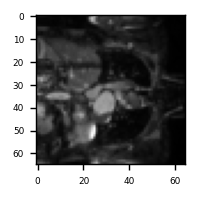

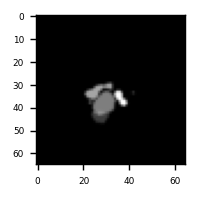

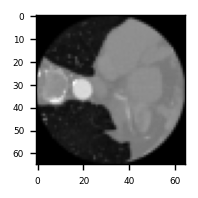

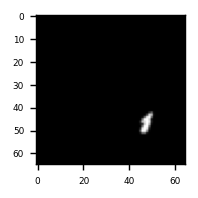

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 5})
from itertools import islice
# ls = list(zip(dataloader, dataloader2))
# print(len(ls))
for _ in range(1):
    # for el in ls:
    for i, batch in islice(zip(dataloader, dataloader2), 80, 81, None):
        
        # plt.imshow(batch[0]["input"][0].detach().cpu().permute(1,2,0)[:,:,0],cmap = 'gray')
        # plt.tight_layout()
        # plt.show()

        '''
        MRI IMAGE
        '''
        # print(batch)
        plt.figure(figsize = (1.5,1.5), dpi=128)
        plt.imshow(i['input'][0].detach().cpu().permute(1,2,0)[:,:,0],cmap = 'gray')
        plt.tight_layout()
        plt.show()
        # print(batch[0]['input'][0].shape)

        '''
        MRI seg mask
        '''

        plt.figure(figsize = (1.5,1.5), dpi=128)
        plt.imshow(i["gt"][0].detach().cpu().permute(1,2,0)[:,:,0],cmap = 'gray')
        plt.tight_layout()
        plt.show()


        '''
        CT image
        '''

        plt.figure(figsize = (1.5,1.5), dpi=128)
        plt.imshow(batch["input"][0].detach().cpu().permute(1,2,0)[:,:,0],cmap = 'gray')
        plt.tight_layout()
        plt.show()

        '''
        CT seg mask
        '''
        plt.figure(figsize = (1.5,1.5), dpi=128)
        plt.imshow(batch["gt"][0].detach().cpu().permute(1,2,0)[:,:,0],cmap = 'gray')
        plt.tight_layout()
        plt.show()

        # break
'''
visualize images
'''
def vis(image):
    plt.imshow(image[0].detach().cpu().permute(1,2,0)[:,:,0],cmap='gray')
    plt.show()

In [ ]:
# https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/21
# https://github.com/tensorflow/tensorflow/blob/85c8b2a817f95a3e979ecd1ed95bff1dc1335cff/tensorflow/python/ops/random_ops.py#L163

def truncated_normal(t, mean=0.0, std=0.01):
    torch.nn.init.normal_(t, mean=mean, std=std)
    while True:
      cond = torch.logical_or(t < mean - 2*std, t > mean + 2*std)
      if not torch.sum(cond):
        break
      t = torch.where(cond.cuda(), torch.nn.init.normal_(torch.ones(t.shape), mean=mean, std=std).cuda(), t.cuda()).cuda()
      
    # return t

def compute_conv_output(H, K, S):
  return int(((H-K+2*0)/S)+1)

def compute_padding(out, H, K, S):
  return int((S*(out-1)-H+K)/2)

def compute_padding_deconv(out, H, K, S):
  return int((-out+(H-1)*S+K)/2)

def compute_maxpool_padding(S, H, f):
  '''
  H2=(H1-f)/s+1
  '''
  return int((S*(H-1)-H+f)/2)


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)

In [ ]:

class General_Conv2D(nn.Module):
    # @torch.no_grad()
    def init_weights(self, n):
      if type(n) == nn.Conv2d:
          truncated_normal(t=n.weight, std=0.01)
          

    def __init__(self, in_features=0, out_features=64, k=7, s=1, stddev=0.01, do_relu=True, keep_rate=None, relu_factor=0, norm_type=None, train=True, padding=False, input_dim=0):
        super(General_Conv2D, self).__init__()
        self.std=stddev
        self.keep_rate=keep_rate
        self.relu_factor=relu_factor
        self.norm_type=norm_type
        self.do_relu=do_relu
        self.k=k
        self.s=s
        self.padding=padding
        self.stddev = stddev

        if not keep_rate is None:
          self.dropout = nn.Dropout(p=keep_rate, inplace=True)
        
        if norm_type=='Batch':
          # if train:
            # self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True).train()
          # else:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True)
        elif norm_type=='Ins':
          # if train:
            # self.instancenorm=nn.InstanceNorm2d(num_features=out_features).train()
          # else:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features)
        
        self.relu=nn.ReLU(inplace=True)
        self.lrealu=nn.LeakyReLU(inplace=True)
        
        self.w= nn.Parameter(torch.randn(out_features, in_features, k,k))
        truncated_normal(t=self.w, std=self.stddev)
        self.b=nn.Parameter(torch.randn(out_features))

    def forward(self, x):

        '''
        initialize weights
        '''
        
        if self.padding==False:
          x = torch.nn.functional.conv2d(x, self.w, self.b, padding=0)

        else:
          
          x = torch.nn.functional.conv2d(x, self.w, self.b, padding=compute_padding(x.shape[-1], x.shape[-1], self.k, self.s))
        
        '''
        dropout
        '''
        if not self.keep_rate is None:
          x=self.dropout(x)

        '''
        norm
        '''
        if (self.norm_type=='Batch'):
          x=self.batchnorm(x)
        elif (self.norm_type=='Ins'):
          x=self.instancenorm(x)

        '''
        act fnc
        '''
        if (self.do_relu==True):
          if (self.relu_factor==0):
            x=self.relu(x)
          else:
            x=self.lrealu(x)
        
        

        return x

        # return x + self.block(x)


class Resnet_Block(nn.Module):
    def __init__(self, in_features, out_features , padding="REFLECT", norm_type=None, keep_rate=0.75):
        super(Resnet_Block, self).__init__()

        if padding=='REFLECT':
          pad_layer=nn.ReflectionPad2d(1)
        elif padding=='CONSTANT':
          pad_layer=nn.ZeroPad2d(1)
        else: # SYMMETRIC
          pad_layer=nn.ReplicationPad2d(1)

        self.block = nn.ModuleList([
            pad_layer,
            General_Conv2D(in_features, out_features, k=3, s=1, stddev=0.01, norm_type=norm_type, keep_rate=keep_rate, padding=False),
            pad_layer,
            General_Conv2D(in_features, out_features, k=3, s=1, stddev=0.01, do_relu=False, norm_type=norm_type, keep_rate=keep_rate, padding=False)
        ])

      
        self.relu=nn.ReLU(inplace=True)

    def forward(self, x):      

        for i in range(len(self.block)):
          if i==0:
            out = self.block[i](x)
          else:
            out = self.block[i](out)

  
        return self.relu(out+x)

class Resnet_Block_ds(nn.Module):
    def __init__(self, in_features=0, out_features=0, padding="REFLECT",dim=0, norm_type=None, keep_rate=None):
        super(Resnet_Block_ds, self).__init__()

        self.in_features=in_features
        self.out_features=out_features

        if padding=='REFLECT':
          pad_layer=nn.ReflectionPad2d(1)
        elif padding=='CONSTANT':
          pad_layer=nn.ZeroPad2d(1)
        else: # SYMMETRIC
          pad_layer=nn.ReplicationPad2d(1)


        self.block = nn.ModuleList([
            
            pad_layer,
            General_Conv2D(in_features, out_features, k=3, s=1, stddev=0.01, norm_type=norm_type, keep_rate=keep_rate, padding=False),
            pad_layer,
            General_Conv2D(out_features, out_features, k=3, s=1, stddev=0.01, do_relu=False, norm_type=norm_type, keep_rate=keep_rate, padding=False)
        ])

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
     
        for i in range(len(self.block)):
          if i==0:
            out = self.block[i](x)
          else:
            out = self.block[i](out)
        '''
        pad channel dim
        '''
        pd=(self.out_features-self.in_features) // 2

        padding = torch.zeros(x.shape[0], pd, x.shape[2], x.shape[3]).cuda()
        padded_inp = torch.cat((x, padding), 1)
        padded_inp = torch.cat((padding, padded_inp), 1)


        return self.relu(out+padded_inp)
  
class drn_Block(nn.Module):
    def __init__(self, in_features, keep_rate=None):
        super(drn_Block, self).__init__()
# TODO remove hard coded
        self.block = nn.Sequential(
            nn.ReflectionPad2d(2),
            nn.Conv2d(in_features, in_features, 3, dilation=2),
            nn.Dropout(1.0, inplace=True),
            nn.BatchNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(2),
            nn.Conv2d(in_features, in_features, 3, dilation=2),
            nn.Dropout(1.0, inplace=True),
            nn.BatchNorm2d(in_features),
        )

        self.relu=nn.ReLU(inplace=True)

    def forward(self, x):
        x = x + self.block(x)
        

        return self.relu(x)



class General_Conv2D_GA(nn.Module):
    # @torch.no_grad()
    def init_weights(self, n):
      if type(n) == nn.Conv2d:
          truncated_normal(n.weight, 0.02)
          

    def __init__(self, in_features=0, out_features=64, k=7, s=1, stddev=0.02, do_relu=True, keep_rate=None, relu_factor=0, norm_type=None, train=True, padding=False, input_dim=0):
        super(General_Conv2D_GA, self).__init__()
        self.std=stddev
        self.keep_rate=keep_rate
        self.relu_factor=relu_factor
        self.norm_type=norm_type
        self.do_relu=do_relu
        self.k=k
        self.s=s
        self.padding=padding
        self.stddev=stddev

        if not keep_rate is None:
          self.dropout = nn.Dropout(p=keep_rate, inplace=True)
        
        if norm_type=='Batch':
          if train:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True).train()
          else:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True)
        elif norm_type=='Ins':
          if train:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features).train()
          else:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features)
        
        self.relu=nn.ReLU(inplace=True)
        self.lrealu=nn.LeakyReLU(inplace=True)
        
        self.w= nn.Parameter(torch.randn(out_features, in_features, k,k))
        truncated_normal(t=self.w, std=self.stddev)
        self.b=nn.Parameter(torch.randn(out_features))
        torch.nn.init.constant_(self.b, 0)

    def forward(self, x):

        '''
        initialize weights
        '''
     
        if self.padding==False:
          x = torch.nn.functional.conv2d(x, self.w, self.b, padding=0)

        else:
          
          x = torch.nn.functional.conv2d(x, self.w, self.b, padding=compute_padding(x.shape[-1], x.shape[-1], self.k, self.s))
        
        '''
        dropout
        # '''
        if not self.keep_rate is None:
          x=self.dropout(x)

        '''
        norm
        '''
        if (self.norm_type=='Batch'):
          x=self.batchnorm(x)
        elif self.norm_type=='Ins':# Instance norm
          x=self.instancenorm(x)

        '''
        act fnc
        '''
        if (self.do_relu==True):
          if (self.relu_factor==0):
            x=self.relu(x)
          else:
            x=self.lrealu(x)
        
       

        return x


class Resnet_Block_ins(nn.Module):
    def __init__(self, in_features=0, out_features=0, padding="REFLECT",dim=0, norm_type=None):
        super(Resnet_Block_ins, self).__init__()

        self.in_features=in_features
        self.out_features=out_features

        if padding=='REFLECT':
          pad_layer=nn.ReflectionPad2d(1)
        elif padding=='CONSTANT':
          pad_layer=nn.ZeroPad2d(1)
        else: # SYMMETRIC
          pad_layer=nn.ReplicationPad2d(1)

        self.block = nn.ModuleList([
            
            pad_layer,
            General_Conv2D_GA(in_features, out_features, k=3, s=1, stddev=0.02, norm_type='Ins', padding=False, do_relu=True),
            pad_layer,
            General_Conv2D_GA(out_features, out_features, k=3, s=1, stddev=0.02, norm_type='Ins', padding=False, do_relu=False)

            ]
        )
        self.relu = torch.nn.ReLU(inplace=True)

    def forward(self, x):
      y=x

      for i in range(len(self.block)):
        if i==0:
          out=self.block[i](x)
        else:
          out=self.block[i](out)
      # out=out.add(y)
      return self.relu(out+y)
      # return self.relu(torch.cat((out,y)))

      # for i in range(len(self.block)):
      #     x=self.block[i](x)
      
      # return self.relu(torch.cat((x,y)))
class General_Deconv2D(nn.Module):
    # @torch.no_grad()
    def init_weights(self, n):
      if type(n) == nn.Conv2d:
          truncated_normal(n.weight, 0.02)
          

    def __init__(self, in_features=0, out_features=64, k=7, s=1, stddev=0.02, do_relu=True, keep_rate=None, relu_factor=0, norm_type=None, train=True, padding=False, input_dim=0, out_shape=0):
        super(General_Deconv2D, self).__init__()
        self.std=stddev
        self.keep_rate=keep_rate
        self.relu_factor=relu_factor
        self.norm_type=norm_type
        self.do_relu=do_relu
        self.k=k
        self.s=s
        self.padding=padding
        self.out_shape=out_shape
        self.stddev=stddev
        
        if norm_type=='Batch':
          if train:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True).train()
          else:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True)
        elif norm_type=='Ins':
          if train:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features).train()
          else:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features)
        
        self.relu=nn.ReLU(inplace=True)
        self.lrealu=nn.LeakyReLU(inplace=True)
        
        self.w= nn.Parameter(torch.randn(in_features, out_features, k,k))
        truncated_normal(self.w, std=self.stddev)
        self.b=nn.Parameter(torch.randn(out_features))
        torch.nn.init.constant_(self.b, 0)

    def forward(self, x):

        if self.padding==False:
          x = torch.nn.functional.conv_transpose2d(x, self.w, bias=self.b, stride=self.s, padding=0)
          # x = torch.nn.functional.conv2d(x, self.w, self.b, padding=0)

        else:
          x = torch.nn.functional.conv_transpose2d(x, self.w, bias=self.b, stride=self.s, padding=compute_padding_deconv(self.out_shape, x.shape[-1], self.k, self.s))
          # x = torch.nn.functional.conv2d(x, self.w, self.b, padding=compute_padding(x.shape[-1], x.shape[-1], self.k, self.s))
        

        '''
        norm
        '''
        if (self.norm_type=='Batch'):
          x=self.batchnorm(x)
        else:# Instance norm
          x=self.instancenorm(x)

        '''
        act fnc
        '''
        if (self.do_relu==True):
          if (self.relu_factor==0):
            x=self.relu(x)
          else:
            x=self.lrealu(x)


        'explicit resize'
        # x=x[:,:,:self.out_shape,:self.out_shape]
        

        return x


  

In [ ]:
class GeneratorResNet(nn.Module):
    def __init__(self, skip=True):
        super(GeneratorResNet, self).__init__()

        self.skip=skip
        # self.input_img=input_img
        self.max_features = 32*4 # used to be 32*4 but there were memory issues.
        
        self.block = nn.ModuleList([
            nn.ZeroPad2d(3),
            General_Conv2D_GA(in_features=1, out_features=32, k=7, s=1, stddev=0.02, do_relu=True, norm_type='Ins', train=True, padding=False),
            General_Conv2D_GA(in_features=32, out_features=32*2, k=3, s=2, stddev=0.02, do_relu=True, norm_type='Ins', train=True, padding=True),
            General_Conv2D_GA(in_features=32*2, out_features=self.max_features, k=3, s=2, stddev=0.02, do_relu=True, norm_type='Ins', train=True, padding=True),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            Resnet_Block_ins(in_features=self.max_features, out_features=self.max_features, padding='CONSTANT'),
            General_Deconv2D(in_features=self.max_features, out_features=32*2, k=3, s=2, stddev=0.02, norm_type='Ins', out_shape=32, padding=True),
            General_Deconv2D(in_features=32*2, out_features=32, k=3, s=2, stddev=0.02, norm_type='Ins', out_shape=64, padding=True),
            General_Conv2D_GA(in_features=32, out_features=1, k=7, s=1, stddev=0.02, do_relu=False, train=True, padding=True),
            ]
            )
        self.tanh = torch.nn.Tanh()
        self.pad = torch.nn.ReflectionPad2d((1,0,1,0))
        
        

    def forward(self, x):

      y=x

      for i in range(len(self.block)):
        if i==0:
          out=self.block[i](x)
        else:
          out=self.block[i](out)

      # y=self.pad(y)
      if self.skip==True:
        return self.tanh(out+y)
      else:
        return self.tanh(out)

    

In [ ]:
'''
input shape: B,C,H,W
'''
class EncoderNet(nn.Module):
    def __init__(self, input_shape):
        super(EncoderNet, self).__init__()
        
        self.input_shape=input_shape

  

        self.out_c1 = General_Conv2D(in_features=1, out_features=16, padding=True, input_dim=self.input_shape[-1], norm_type='Batch', keep_rate=1.0)
        self.out_res1 = Resnet_Block(in_features=16,out_features=16,norm_type='Batch', keep_rate=1.0)
        self.out1 = nn.MaxPool2d(kernel_size=1, stride=1, padding=compute_maxpool_padding(S=1, H=input_shape[-1], f=1))
        
        self.out_res2 = Resnet_Block_ds(in_features=16, out_features=16*2, norm_type='Batch', padding='CONSTANT', keep_rate=1.0)

        self.out_res3 = Resnet_Block_ds(in_features=16*2, out_features=16*4, norm_type='Batch', padding='CONSTANT', keep_rate=1.0)
        self.out_res4 = Resnet_Block(in_features=16*4,out_features=16*4,norm_type='Batch', padding='CONSTANT', keep_rate=1.0)

        self.out_res5 = Resnet_Block_ds(in_features=16*4,out_features=16*8,norm_type='Batch', padding='CONSTANT', keep_rate=1.0)
        self.out_res6 = Resnet_Block(in_features=16*8,out_features=16*8,norm_type='Batch', padding='CONSTANT', keep_rate=1.0)

        self.out_res7 = Resnet_Block_ds(in_features=16*8,out_features=16*16,norm_type='Batch', padding='CONSTANT', keep_rate=1.0)
        self.out_res8 = Resnet_Block(in_features=16*16,out_features=16*16,norm_type='Batch', padding='CONSTANT', keep_rate=1.0)

        self.out_res9 = Resnet_Block(in_features=16*16,out_features=16*16,norm_type='Batch', padding='CONSTANT', keep_rate=1.0)
        self.out_res10= Resnet_Block(in_features=16*16,out_features=16*16,norm_type='Batch', padding='CONSTANT', keep_rate=1.0)

        self.out_res11= Resnet_Block_ds(in_features=16*16,out_features=16*32,norm_type='Batch', padding='CONSTANT', keep_rate=1.0)
        self.out_res12= Resnet_Block(in_features=16*32,out_features=16*32,norm_type='Batch', padding='CONSTANT', keep_rate=1.0)

        self.out_drn1 = drn_Block(in_features=16*32, keep_rate=1.0)
        self.out_drn2 = drn_Block(in_features=16*32, keep_rate=1.0)
        
        self.out_c2 = General_Conv2D(in_features=16*32, out_features=16*32, k=3, padding=True, input_dim=0, norm_type='Batch', keep_rate=1.0)
        self.out_c3 = General_Conv2D(in_features=16*32, out_features=16*32, k=3, padding=True, input_dim=0, norm_type='Batch', keep_rate=1.0)


    def forward(self, x):
  
        '''
        separate kernel size implementation from tf not available in pytorch
        TODO
        '''
        x=self.out_c1(x)
        x=self.out_res1(x)
        x=self.out1(x)
        x=self.out_res2(x)
        x=torch.nn.functional.max_pool2d(x,kernel_size=1, stride=1, padding=compute_maxpool_padding(S=1, H=x.shape[-1], f=1))
        # self.out2 = nn.MaxPool2d(kernel_size=1, stride=1, padding=compute_maxpool_padding(S=1, H=x.shape[-1], f=1))
        # x=self.out2(x)
        x=self.out_res3(x)
        x=self.out_res4(x)
        x=torch.nn.functional.max_pool2d(x,kernel_size=1, stride=1, padding=compute_maxpool_padding(S=1, H=x.shape[-1], f=1))
        # self.out3 = nn.MaxPool2d(kernel_size=1, stride=1, padding=compute_maxpool_padding(S=1, H=x.shape[-1], f=1))
        # x=self.out3(x)
        x=self.out_res5(x)
        x=self.out_res6(x)
        x=self.out_res7(x)
        x=self.out_res8(x)
        x=self.out_res9(x)
        x=self.out_res10(x)
       
        x=self.out_res11(x)
        x=self.out_res12(x)
        y=x
        x=self.out_drn1(x)
        x=self.out_drn2(x)
        '''
        '''
        x=self.out_c2(x)
        x=self.out_c3(x)

        return x, y

In [ ]:
class DecoderNet(nn.Module):
    def __init__(self, input_shape, skip=False):
        super(DecoderNet, self).__init__()
        
        self.skip=skip
        self.input_shape=input_shape
        
        self.block = nn.ModuleList([
          General_Conv2D(in_features=self.input_shape[1], k=3, s=1, out_features=32*4, padding=True, input_dim=self.input_shape[-1], norm_type='Ins'),
          Resnet_Block(in_features=32*4,out_features=32*4, padding='CONSTANT', norm_type='Ins', keep_rate=0.75),
          Resnet_Block(in_features=32*4,out_features=32*4,padding='CONSTANT',norm_type='Ins', keep_rate=0.75),
          Resnet_Block(in_features=32*4,out_features=32*4,padding='CONSTANT',norm_type='Ins', keep_rate=0.75),
          Resnet_Block(in_features=32*4,out_features=32*4,padding='CONSTANT',norm_type='Ins', keep_rate=0.75),
          General_Deconv2D(in_features=32*4, out_features=32*2, k=3, s=2, stddev=0.02, norm_type='Ins', out_shape=16, padding=True),
          General_Deconv2D(in_features=32*2, out_features=32*2, k=3, s=2, stddev=0.02, norm_type='Ins', out_shape=32, padding=True),
          General_Deconv2D(in_features=32*2, out_features=32, k=3, s=2, stddev=0.02, norm_type='Ins', out_shape=64, padding=True),
          General_Conv2D(in_features=32, out_features=1, k=7, s=1, norm_type=None, do_relu=False, stddev=0.02, padding=True, input_dim=self.input_shape[-1])
        ])

        self.tanh = nn.Tanh()

    def forward(self, x, input_img):
      for i in range(len(self.block)):
        if i==0:
          out=self.block[i](x)
        else:
          out=self.block[i](out)

      if self.skip==True:
        return self.tanh(input_img+out)
      else:
        return self.tanh(out)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_shape, skip=False):
        super(Discriminator, self).__init__()
        
        self.skip=skip
        self.input_shape=input_shape

        self.block = nn.ModuleList([
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=input_shape[0], out_features=64, k=4, s=2, stddev=0.02, padding=False, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type=None),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64, out_features=64*2, k=4, s=2, stddev=0.02, padding=False, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type='Ins'),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64*2, out_features=64*4, k=4, s=2, stddev=0.02, padding=False, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type='Ins'),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64*4, out_features=64*8, k=4, s=1, stddev=0.02, padding=False, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type='Ins'),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64*8, out_features=1, k=4, s=1, stddev=0.02, padding=False, input_dim=self.input_shape[-1], norm_type=None, do_relu=False),
        ]
        )

    def forward(self, x):
      for i in range(len(self.block)):
          x=self.block[i](x)
      return x


In [ ]:
class Discriminator_aux(nn.Module):
    def __init__(self, input_shape, skip=False):
        super(Discriminator_aux, self).__init__()
        
        self.skip=skip
        self.input_shape=input_shape

        self.block = nn.ModuleList([
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=1, out_features=64, k=4, s=2, stddev=0.02, padding=False, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type=None),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64, out_features=64*2, k=4, s=2, stddev=0.02, padding=False, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type='Ins'),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64*2, out_features=64*4, k=4, s=2, stddev=0.02, padding=False, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type='Ins'),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64*4, out_features=64*8, k=4, s=1, stddev=0.02, padding=False, relu_factor=0.02, input_dim=self.input_shape[-1], norm_type='Ins'),
          nn.ZeroPad2d(2),
          General_Conv2D(in_features=64*8, out_features=1, k=4, s=1, stddev=0.02, padding=False, input_dim=self.input_shape[-1], norm_type=None, do_relu=False),
        ])

    def forward(self, x):
      for i in range(len(self.block)):
          x=self.block[i](x)
      # return out, out
      # x1=x[...,0]
      # x2=x[...,1]
      # return torch.unsqueeze(x1, dim=3), torch.unsqueeze(x2, dim=3)
      return torch.unsqueeze(x[...,0], dim=3), torch.unsqueeze(x[...,1], dim=3) 

In [ ]:
class Segmenter(nn.Module):
    def __init__(self, keep_rate):
      super(Segmenter, self).__init__()

      self.l1 = General_Conv2D(in_features=64*8, out_features=5, k=1, s=1, stddev=0.01, padding=True, relu_factor=0, do_relu=False, keep_rate=keep_rate, norm_type=None)
      # self.up = torch.nn.Upsample((65,65), mode='bilinear')
    def forward(self, x):
      x=self.l1(x)
      # x=self.up(x)
      x=torch.nn.functional.interpolate(x, size=(65,65), mode='bilinear', align_corners=None)
      return x

In [ ]:
'''
Params for cycle loss calculation
'''
LAMBDA_A=10
LAMBDA_B=10

In [ ]:
'''
Losses
'''

'''
Copute lsgan loss for generator
'''
def lsgan_loss_generator(prob_fake_is_real):
    return (torch.mean((prob_fake_is_real - 1)**2))

'''
Compute lsgan loss (which needs to be minimized) (lsgan to help with vanishing/exploding gradients)?
'''
def lsgan_loss_discriminator(prob_real_is_real, prob_fake_is_real):
    return (torch.mean((prob_real_is_real - 1)**2) + torch.mean((prob_fake_is_real - 0)**2))*0.5


'''
Compute cycle loss
'''
def cycle_consistency_loss(real_images, generated_images):
    return (torch.mean(torch.abs(real_images - generated_images)))


'''
Weighted softmax loss
'''
def softmax_weighted_loss(logits, gt):
  softmax=torch.nn.Softmax()
  # softmaxpred = softmax(logits)
  # softmaxpred=torch.softmax(logits)
  softmaxpred=torch.nn.functional.softmax(logits, dim=1)
  for i in range(5):
    gti = gt[:,i,:,:]
    predi=softmaxpred[:,i,:,:]
    weighted = 1-(torch.sum(gti)/torch.sum(gt))
    if i==0:
      raw_loss = -1.0 * weighted * gti * torch.log(torch.clamp(predi, 0.005, 1))
    else:
      raw_loss += -1.0 * weighted * gti * torch.log(torch.clamp(predi, 0.005, 1))
  loss=torch.mean(raw_loss)
  return loss
'''
Dice loss
'''
def _dice_loss(logits, gt):
  dice=0
  eps=1e-7
  # softmax=torch.nn.Softmax()
  # softmaxpred = softmax(logits)
  # softmaxpred=torch.softmax(logits, dim=1)
  softmaxpred=torch.nn.functional.softmax(logits, dim=1)
  for i in range(5):
    inse = torch.sum(softmaxpred[:,i,:,:]*gt[:,i,:,:])
    l = torch.sum(softmaxpred[:,i,:,:]*softmaxpred[:,i,:,:])
    r = torch.sum(gt[:,i,:,:])
    dice += 2.0 * inse/(l+r+eps)
  return 1-1.0*dice/5
'''
Task loss:
cross entropy loss + dice loss
'''
def task_loss(prediction, gt):
  ce_loss = softmax_weighted_loss(prediction, gt)
  dice_loss = _dice_loss(prediction, gt)
  return ce_loss, dice_loss


'''
l2 loss
'''
def l2_loss():
  tensors=[]
  for param in segmenter.parameters():
    tensors.append(0.0001*(torch.sum(param.data**2)/2))
  for param in segmenter_II.parameters():
    tensors.append(0.0001*(torch.sum(param.data**2)/2))
  for param in Encoder.parameters():
    tensors.append(0.0001*(torch.sum(param.data**2)/2))
  re=0.0
  for val in tensors:
    re+=val
  return 0


In [ ]:
import argparse
import os
import numpy as np
import math
import itertools
import datetime
import time
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import sys
import random
import pickle
import tensorflow as tf

cuda = torch.cuda.is_available()

'''
Encoder
'''
Encoder = EncoderNet(input_shape=(2,1,64,64))
'''
Decoder
'''
Decoder = DecoderNet(input_shape=(1,512,64,64), skip=True)

'''
Discriminator
'''
discriminator = Discriminator((1,64,64))
discriminator_aux = Discriminator_aux((1,64,64))

'''
Generator
'''
G_A=GeneratorResNet(skip=True)

'''
Segmenter
'''
segmenter=Segmenter(keep_rate=1.0)
segmenter_II=Segmenter(keep_rate=1.0)

'''
Discriminator (seg)
'''
discriminator_p = Discriminator((5,64,64))
discriminator_p_II = Discriminator((5,64,64))

if cuda:
    Encoder = Encoder.cuda()
    Decoder = Decoder.cuda()
    discriminator = discriminator.cuda()
    discriminator_aux=discriminator_aux.cuda()
    G_A=G_A.cuda()
    segmenter=segmenter.cuda()
    segmenter_II=segmenter_II.cuda()
    discriminator_p=discriminator_p.cuda()
    discriminator_p_II=discriminator_p_II.cuda()


opt={"lr":0.0002,"b1":0.5, "b2":0.999, "epoch":0, "n_epochs":20000, "decay_epoch":5, "lambda_cyc":10.0, "lambda_id":5.0}


optimizer_G = torch.optim.Adam(itertools.chain(G_A.parameters(), Decoder.parameters()), lr=opt["lr"], betas=(opt["b1"], opt["b2"]))
# optimizer_G_A = torch.optim.Adam(G_A.parameters(), lr=opt["lr"], betas=(opt["b1"], opt["b2"]))
# optimizer_G_B = torch.optim.Adam(Decoder.parameters(), lr=opt["lr"], betas=(opt["b1"], opt["b2"]))
optimizer_D_A = torch.optim.Adam(discriminator_aux.parameters(), lr=opt["lr"], betas=(opt["b1"], opt["b2"]))
optimizer_D_B = torch.optim.Adam(discriminator.parameters(), lr=opt["lr"], betas=(opt["b1"], opt["b2"]))
optimizer_seg = torch.optim.Adam(itertools.chain(segmenter.parameters(), segmenter_II.parameters(), Encoder.parameters()), lr=opt["lr"])
optimizer_D_P = torch.optim.Adam(discriminator_p.parameters(), lr=opt["lr"], betas=(opt["b1"], opt["b2"]))
optimizer_D_P_II=torch.optim.Adam(discriminator_p_II.parameters(), lr=opt["lr"], betas=(opt["b1"], opt["b2"]))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
G_A.train()
discriminator.train()
Encoder.train()
Decoder.train()
discriminator_aux.train()
segmenter.train()
segmenter_II.train()
discriminator_p.train()
discriminator_p_II.train()

'''
Training loop starts
'''
for epoch in range(opt["n_epochs"]):
    for i, batch in islice(zip(dataloader, dataloader2),80, 81, None):
      #  
        # if (i==1): # trying to overfit on single image
          # i=0
          # break
        G_A.train()
        discriminator.train()
        Encoder.train()
        Decoder.train()
        discriminator_aux.train()
        segmenter.train()
        segmenter_II.train()
        discriminator_p.train()
        discriminator_p_II.train()
        with torch.autograd.set_detect_anomaly(True):
          

          real_A = Variable(i["input"].type(Tensor)) # mri
          real_B = Variable(batch["input"].type(Tensor)) # ct

          gt_A = Variable(i["gt"].type(Tensor)) # mri
          gT_B = Variable(batch["gt"].type(Tensor)) # ct

          '''
          Normalize?
          '''
          # gt_A = (2*((gt_A - torch.min(gt_A))/(torch.max(gt_A)-torch.min(gt_A))))-1


          '''
          ??Transform gt labels to have 5 dimensions. Onehot. 
          '''
          print(real_A.shape)
          print(gt_A.shape)
          gt_A=gt_A.detach().cpu()
          gt_A=gt_A.numpy()
          np_tensor=gt_A
          physical_devices = tf.config.list_physical_devices('GPU')
          tf.config.experimental.set_memory_growth(physical_devices[0], True)
          tf_tensor=tf.convert_to_tensor(np_tensor)
          inter=tf.one_hot(tf.cast(tf.squeeze(tf_tensor), tf.uint8), 5)
          gt_A=torch.from_numpy(inter.numpy())
          gt_A=gt_A.permute(2,0,1)
          gt_A=gt_A.unsqueeze(0)
          gt_A=gt_A.to('cuda')
          gt_A.requires_grad=True



          # TODO uint8 in tf code
          # gt_A=gt_A.detach()
          # torch.set_printoptions(threshold=10_000)
          # y=torch.squeeze(gt_A).type(torch.uint8)
          # print(y)
          # print(torch.unique(y))
          # y=F.one_hot(torch.squeeze(y).type(torch.uint8), num_classes=5)
          # print(y)
          # vis(y)
          # print(torch.unique(y))
          # gt_A=F.one_hot(torch.squeeze(gt_A).type(torch.LongTensor), num_classes=5)
          
          
          
          '''
          Normalize data b/w -1,1 range
          '''
          real_A = (2*((real_A - torch.min(real_A))/(torch.max(real_A)-torch.min(real_A))))-1
          real_B = (2*((real_B - torch.min(real_B))/(torch.max(real_B)-torch.min(real_B))))-1

          ################ Computing GAN Losses
          '''
          Optimizing G_A network
          (real_A -> fake_B)
          '''

          # optimizer_G_A.zero_grad()
          # optimizer_G_B.zero_grad()
          optimizer_G.zero_grad()
          optimizer_seg.zero_grad() # Encoder and seg1 + seg2


          fake_imgs_b = G_A(real_A)

          '''
          D_B Discriminator
          '''
          prob_fake_b_is_real = discriminator(fake_imgs_b)
          lsgan_loss_b = lsgan_loss_generator(prob_fake_b_is_real)

          

          '''
          Optimizing the G_B network E/D 
          (real_B -> fake_A)
          '''

          latent_real_b, latent_real_b_II = Encoder(real_B)
          fake_imgs_a = Decoder(latent_real_b, real_B)

          '''
          Optimizing Segmentation network real
          '''
          # optimizer_seg.zero_grad() # Encoder and seg1 + seg2
          pred_mask_b = segmenter(latent_real_b)
          pred_mask_b_II=segmenter_II(latent_real_b_II)

          '''
          D_A discriminator
          '''
          prob_fake_a_is_real, prob_fake_a_aux_is_real = discriminator_aux(fake_imgs_a)
          lsgan_loss_a = lsgan_loss_generator(prob_fake_a_is_real)

          '''
          Not adding lsgan_loss_a and lsgan_loss_b ?
          '''

          ##################### GAN Cycle loss

          latent_fake_b, latent_fake_b_II = Encoder(fake_imgs_b)
          cycle_imgs_a = Decoder(latent_fake_b, fake_imgs_b)

          '''
          Optimizing Segmentation network fake
          '''
          pred_mask_fake_b=segmenter(latent_fake_b)
          # ce_loss_b, dice_loss_b = task_loss(pred_mask_fake_b, gt_A)
          pred_mask_fake_b_II=segmenter_II(latent_fake_b_II)

          cycle_consistency_loss_a = LAMBDA_A * cycle_consistency_loss(real_images=real_A, generated_images=cycle_imgs_a)
          
          cycle_imgs_b = G_A(fake_imgs_a)
          cycle_consistency_loss_b = LAMBDA_B * cycle_consistency_loss(real_images=real_B, generated_images=cycle_imgs_b)

          
          ####################### Total Generator losses (not adding g_loss_a and g_loss_b ?)
          '''
          final G_A loss 
          '''
          g_loss_a = cycle_consistency_loss_a + cycle_consistency_loss_b + lsgan_loss_b
          '''
          final E/D loss
          '''
          g_loss_b = cycle_consistency_loss_b + cycle_consistency_loss_a + lsgan_loss_a

          '''
          backward
          '''
          g_loss_a.backward(retain_graph=True)
          # optimizer_G_A.step() # Generator
          g_loss_b.backward(retain_graph=True)
          # optimizer_G_B.step() # Decoder
          # optimizer_G.step()

          ############### Computing Discriminator losses
          ############### Computing D_A loss

          optimizer_D_B.zero_grad()
          '''
          Optimizing the D_B network
          '''
          
          fake_pool_b=fake_imgs_b
          fake_pool_b=fake_pool_b.detach()
          prob_real_b_is_real = discriminator(real_B)
          prob_fake_pool_b_is_real = discriminator(fake_pool_b)

          d_loss_b = lsgan_loss_discriminator(prob_real_b_is_real, prob_fake_pool_b_is_real)

          '''
          backward
          '''
          d_loss_b.backward(retain_graph=True)
          # optimizer_D_B.step()

          ############### Computing D_B loss
          '''
          Optimizing the D_A network
          '''

          optimizer_D_A.zero_grad()
          
          fake_pool_a = fake_imgs_a
          fake_pool_a=fake_pool_a.detach()
          prob_real_a_is_real, prob_real_a_aux = discriminator_aux(real_A)
          prob_fake_pool_a_is_real, prob_fake_pool_a_aux_is_real = discriminator_aux(fake_pool_a)

          d_loss_a = lsgan_loss_discriminator(
              prob_real_a_is_real,
              prob_fake_pool_a_is_real,
          )

          '''
          ???? 
          '''
          cycle_imgs_a=cycle_imgs_a.detach()
          prob_cycle_a_is_real, prob_cycle_a_aux_is_real = discriminator_aux(cycle_imgs_a)

          d_loss_a_aux = lsgan_loss_discriminator(
              prob_cycle_a_aux_is_real,
              prob_fake_pool_a_aux_is_real,
          )

          d_loss_a = d_loss_a + d_loss_a_aux

          '''
          backward
          '''
          d_loss_a.backward(retain_graph=True)
          # optimizer_D_A.step()
          
          # optimizer_seg.zero_grad() # Encoder and seg1 + seg2

  
          ce_loss_b, dice_loss_b = task_loss(pred_mask_fake_b, gt_A)
          # loss = nn.MSELoss()
          # gt_A=gt_A.to(torch.float)
          # ce_loss_b = loss(pred_mask_fake_b, gt_A)
          
          ce_loss_b_II, dice_loss_b_II = task_loss(pred_mask_fake_b_II, gt_A)
          l2_loss_b = l2_loss()


          '''
          Discriminator P
          '''          

          optimizer_D_P.zero_grad()
          optimizer_D_P_II.zero_grad()

          prob_pred_mask_b_is_real=discriminator_p(pred_mask_b)#################
          lsgan_loss_p=lsgan_loss_generator(prob_pred_mask_b_is_real)

          '''
          Discriminator P II
          '''
          prob_pred_mask_b_II_is_real=discriminator_p_II(pred_mask_b_II) ###############
          lsgan_loss_p_II=lsgan_loss_generator(prob_pred_mask_b_II_is_real)     
          
          lsgan_loss_a_aux=lsgan_loss_generator(prob_fake_a_aux_is_real)

          seg_loss = ce_loss_b + dice_loss_b + l2_loss_b + 0.1*(ce_loss_b_II + dice_loss_b_II) +0.1*g_loss_b +0.1*lsgan_loss_p+0.01*lsgan_loss_p_II+0.1*lsgan_loss_a_aux
          
          seg_loss.backward(retain_graph=True)
          # optimizer_seg.step()

          
          # optimizer_G.step()
          # optimizer_D_A.step()
          # optimizer_D_B.step()

          '''
          optimizing D_P
          '''
          # optimizer_D_P.zero_grad()

          prob_pred_mask_fake_b_is_real=discriminator_p(pred_mask_fake_b)
          
          
          d_loss_P = lsgan_loss_discriminator(
              prob_pred_mask_fake_b_is_real,
              prob_pred_mask_b_is_real,
          )
          d_loss_P.backward(retain_graph=True)
          # optimizer_D_P.step()

          '''
          optimizing D_P_II
          '''
          

          prob_pred_mask_fake_b_II_is_real = discriminator_p_II(pred_mask_fake_b_II)
      

          d_loss_P_II = lsgan_loss_discriminator(
              prob_pred_mask_fake_b_II_is_real,
              prob_pred_mask_b_II_is_real
          )

          d_loss_P_II.backward()

          optimizer_D_P_II.step()
          optimizer_D_P.step()

          optimizer_seg.step()

          
          optimizer_G.step()
          optimizer_D_A.step()
          optimizer_D_B.step()

          # optimizer_D_P_II


          # sys.stdout.write(
          #     "[Epoch %d/%d] [Batch %d/%d] [D_A loss: %f] [D_B loss: %f] [G_A loss: %f] [G_B loss: %f]\n"
          #     % (
          #         epoch,
          #         opt["n_epochs"],
          #         i,
          #         len(dataloader),
          #         d_loss_a.item(),
          #         d_loss_b.item(),
          #         g_loss_a.item(),
          #         g_loss_b.item(),
          #     )
          # )

          '''
          Putting assertions to make sure gradients flow
          '''
          for param in list(discriminator.parameters()):
            assert param.grad is not None

          for param in list(G_A.parameters()):
            assert param.grad is not None

          for param in list(discriminator_aux.parameters()):
            assert param.grad is not None

          for param in list(Encoder.parameters()):
            assert param.grad is not None

          for param in list(Decoder.parameters()):
            assert param.grad is not None

          for param in list(segmenter.parameters()):
            assert param.grad is not None

          for param in list(segmenter_II.parameters()):
            assert param.grad is not None

          for param in list(discriminator_p_II.parameters()):
            assert param.grad is not None

          for param in list(discriminator_p.parameters()):
            assert param.grad is not None

          sys.stdout.write(
              "\r[Epoch %d/%d] [G_A loss: %f] [D_B loss: %f]"
              % (
                  epoch,
                  opt["n_epochs"],
                  g_loss_b.item(),
                  d_loss_b.item()
              )
          )
          
          if epoch%100==0:
            soft=torch.nn.functional.softmax(pred_mask_fake_b,dim=1)
            args=torch.argmax(soft.detach().cpu(), dim=1)
            args=torch.squeeze(args)
            ne=args.clone()
            for i in range(65):
                for j in range(65):
                    ne[i][j]=pred_mask_fake_b[0].permute(1,2,0)[i,j,args[i][j]]

            plt.imshow(ne, cmap='gray')
            plt.show()
          
        if epoch%1000==0:
          with open('fakeb'+str(epoch)+'.pickle', 'wb') as f:
            pickle.dump(fake_imgs_b, f)
          with open('fakea'+str(epoch)+'.pickle', 'wb') as f:
            pickle.dump(fake_imgs_a, f)
          with open('cyclea'+str(epoch)+'.pickle', 'wb') as f:
            pickle.dump(cycle_imgs_a, f)
          with open('cycleb'+str(epoch)+'.pickle', 'wb') as f:
            pickle.dump(cycle_imgs_b, f)
          with open('pred_mask_fake_b'+str(epoch)+'.pickle', 'wb') as f:
            pickle.dump(pred_mask_fake_b, f)
          with open('pred_mask_fake_b_II'+str(epoch)+'.pickle', 'wb') as f:
            pickle.dump(pred_mask_fake_b_II, f)
          with open('pred_mask_b'+str(epoch)+'.pickle', 'wb') as f:
            pickle.dump(pred_mask_b, f)
          with open('pred_mask_b_II'+str(epoch)+'.pickle', 'wb') as f:
            pickle.dump(pred_mask_b_II, f)

        G_A.eval()
        discriminator.eval()
        Encoder.eval()
        Decoder.eval()
        discriminator_aux.eval()
        segmenter.eval()
        segmenter_II.eval()
        discriminator_p.eval()
        discriminator_p_II.eval()

        with torch.no_grad():
          


          fake_imgs_b = G_A(real_A)

          '''
          Optimizing the G_B network E/D 
          (real_B -> fake_A)
          '''

          latent_real_b, latent_real_b_II = Encoder(real_B)
          fake_imgs_a = Decoder(latent_real_b, real_B)

          '''
          Optimizing Segmentation network real
          '''
          # optimizer_seg.zero_grad() # Encoder and seg1 + seg2
          pred_mask_b = segmenter(latent_real_b)
          pred_mask_b_II=segmenter_II(latent_real_b_II)

  
          latent_fake_b, latent_fake_b_II = Encoder(fake_imgs_b)
          cycle_imgs_a = Decoder(latent_fake_b, fake_imgs_b)

          '''
          Optimizing Segmentation network fake
          '''
          pred_mask_fake_b=segmenter(latent_fake_b)
          # ce_loss_b, dice_loss_b = task_loss(pred_mask_fake_b, gt_A)
          pred_mask_fake_b_II=segmenter_II(latent_fake_b_II)

          cycle_imgs_b = G_A(fake_imgs_a)

          if epoch%1000==0:
            with open('evalfakeb'+str(epoch)+'.pickle', 'wb') as f:
              pickle.dump(fake_imgs_b, f)
            with open('evalfakea'+str(epoch)+'.pickle', 'wb') as f:
              pickle.dump(fake_imgs_a, f)
            with open('evalcyclea'+str(epoch)+'.pickle', 'wb') as f:
              pickle.dump(cycle_imgs_a, f)
            with open('evalcycleb'+str(epoch)+'.pickle', 'wb') as f:
              pickle.dump(cycle_imgs_b, f)
            with open('evalpred_mask_fake_b'+str(epoch)+'.pickle', 'wb') as f:
              pickle.dump(pred_mask_fake_b, f)
            with open('evalpred_mask_fake_b_II'+str(epoch)+'.pickle', 'wb') as f:
              pickle.dump(pred_mask_fake_b_II, f)
            with open('evalpred_mask_b'+str(epoch)+'.pickle', 'wb') as f:
              pickle.dump(pred_mask_b, f)
            with open('evalpred_mask_b_II'+str(epoch)+'.pickle', 'wb') as f:
              pickle.dump(pred_mask_b_II, f)




torch.Size([1, 1, 65, 65])
torch.Size([1, 1, 65, 65])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


RuntimeError: ignored

In [ ]:
# plt.imshow(pred_mask_fake_b[0].detach().cpu().permute(1,2,0)[:,:,0],cmap='gray')
# plt.show()
vis(pred_mask_fake_b)
a=torch.nn.functional.softmax(pred_mask_fake_b)
# vis(a)
print(a.shape)
b=torch.argmax(a, dim=1)
print(b.shape)
print(1 in b)
# print(b[0].shape)
# plt.imshow(torch.squeeze(b[0].detach().cpu()),cmap='gray')

In [ ]:
with open('fakebfinal.pickle', 'wb') as f:
  pickle.dump(fake_imgs_b, f)
with open('fakeafinal.pickle', 'wb') as f:
  pickle.dump(fake_imgs_a, f)
with open('cyclebfinal.pickle', 'wb') as f:
  pickle.dump(cycle_imgs_b, f)
with open('cycleafinal.pickle', 'wb') as f:
  pickle.dump(cycle_imgs_a, f)
with open('pred_mask_fake_bfinal.pickle', 'wb') as f:
  pickle.dump(pred_mask_fake_b, f)
with open('pred_mask_fake_b_IIfinal.pickle', 'wb') as f:
  pickle.dump(pred_mask_fake_b_II, f)
with open('pred_mask_bfinal.pickle', 'wb') as f:
  pickle.dump(pred_mask_b, f)
with open('pred_mask_b_IIfinal.pickle', 'wb') as f:
  pickle.dump(pred_mask_b_II, f)

In [ ]:
# vis(fake_imgs_a)

In [ ]:
# '''
# Visualizing generator outputs
# '''
# plt.imshow(cycle_imgs_a.detach().cpu().squeeze(),cmap='gray')
# plt.show()
# plt.imshow(fake_imgs_b.detach().cpu().squeeze(),cmap='gray')
# plt.show()
# plt.imshow(real_A.detach().cpu().squeeze(),cmap='gray')
# plt.show()